In [91]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
from pathlib import Path
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.interpolate import griddata

class readerFile:

    def __init__(self, file_path):
        self.file_path = file_path
        header, data = self.__read_file()

        hdu = fits.PrimaryHDU(data)
        self.__get_header_format(header, hdu)

        hdul = fits.HDUList([hdu])
        # self.header = header
        self.hdul = hdul

    def read(self):
        return self.hdul
        

    def __read_file(self):
        header = []
        
        with open(self.file_path, 'r') as file:
            lines = file.readlines()
            
            # Skip the first empty line
            lines = lines[1:]  # Skip first empty line
            
            # Now separate the header and content
            header_found = False
            for i, line in enumerate(lines):
                if header_found:
                    break
                elif line.strip() == '':  # Empty line indicates end of header
                    header_found = True
                else:
                    header.append(line.strip())
    
        data = np.genfromtxt(self.file_path, unpack=True, skip_header=107)
        return header, data

    def __parse_value(self, value):
        """Parse the string value to the appropriate type (float, int, or str)."""
        value_stripped = value.strip()  # Remove any leading/trailing whitespace
        # Try converting to an int first
        if value_stripped.isdigit():  # Check if it's a positive integer
            return int(value_stripped)
        # Try converting to a float next
        try:
            return float(value_stripped)
        except ValueError:
            return value_stripped  # Return as string if not float or int


    def __get_header_format(self, header, hdu):

        for line in header:
            param_name, param_val = line.split(':')
            parsed_value = self.__parse_value(param_val)

            hdu.header[param_name] = parsed_value

        return

In [3]:
mypath = r"C:\Users\nicol\Documents\Astro_Exp\Radio 1\datos_espectros\sdf*"
# spectra_paths = [str(f) for f in mypath.iterdir() if f.is_file()]
spectra_paths = sorted(glob.glob(mypath))


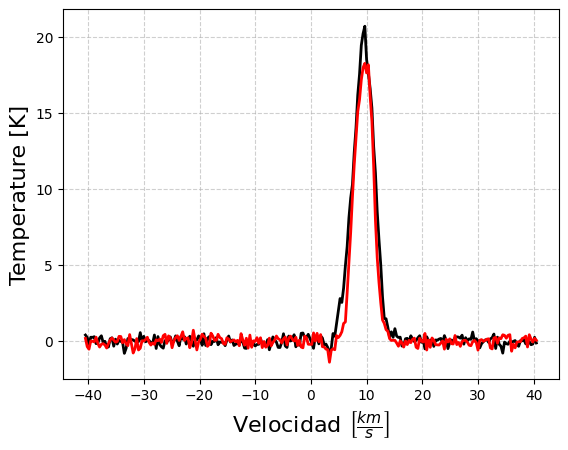

In [74]:
spectra_FITS = []
for j in spectra_paths:
    spectra_j = readerFile(j).read()
    spectra_FITS += spectra_j

spectra_xy = []
for i in spectra_FITS:
    hdr = i.header
    bii, lii = hdr['BII'], hdr['LII']
    spectra_xy.append([bii, lii])

spec_T = []
for i in range(len(spectra_FITS)):
    v, T = spectra_FITS[i].data
    spec_T.append(T)


plt.plot(v, spec_T[0], color="black", linestyle="-", linewidth=2)
plt.plot(v, spec_T[1], color="red", linestyle="-", linewidth=2)
plt.xlabel(r"Velocidad $\left[ \frac{km}{s}\right]$", fontsize=16)
plt.ylabel(r"Temperature [K]", fontsize=16)

plt.grid(True, linestyle="--", alpha=0.6)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()



In [32]:
stack_T = np.stack(spec_T)
sumas_T = np.cumsum(stack_T, axis = 0)

div = np.arange(1, len(spec_T)+1).reshape(-1, 1)

means_T = sumas_T/div


In [33]:
def fn_gauss(x,T0,mean,stdv):
    return T0*np.exp(-((x-mean)**2)/(2*(stdv**2)))

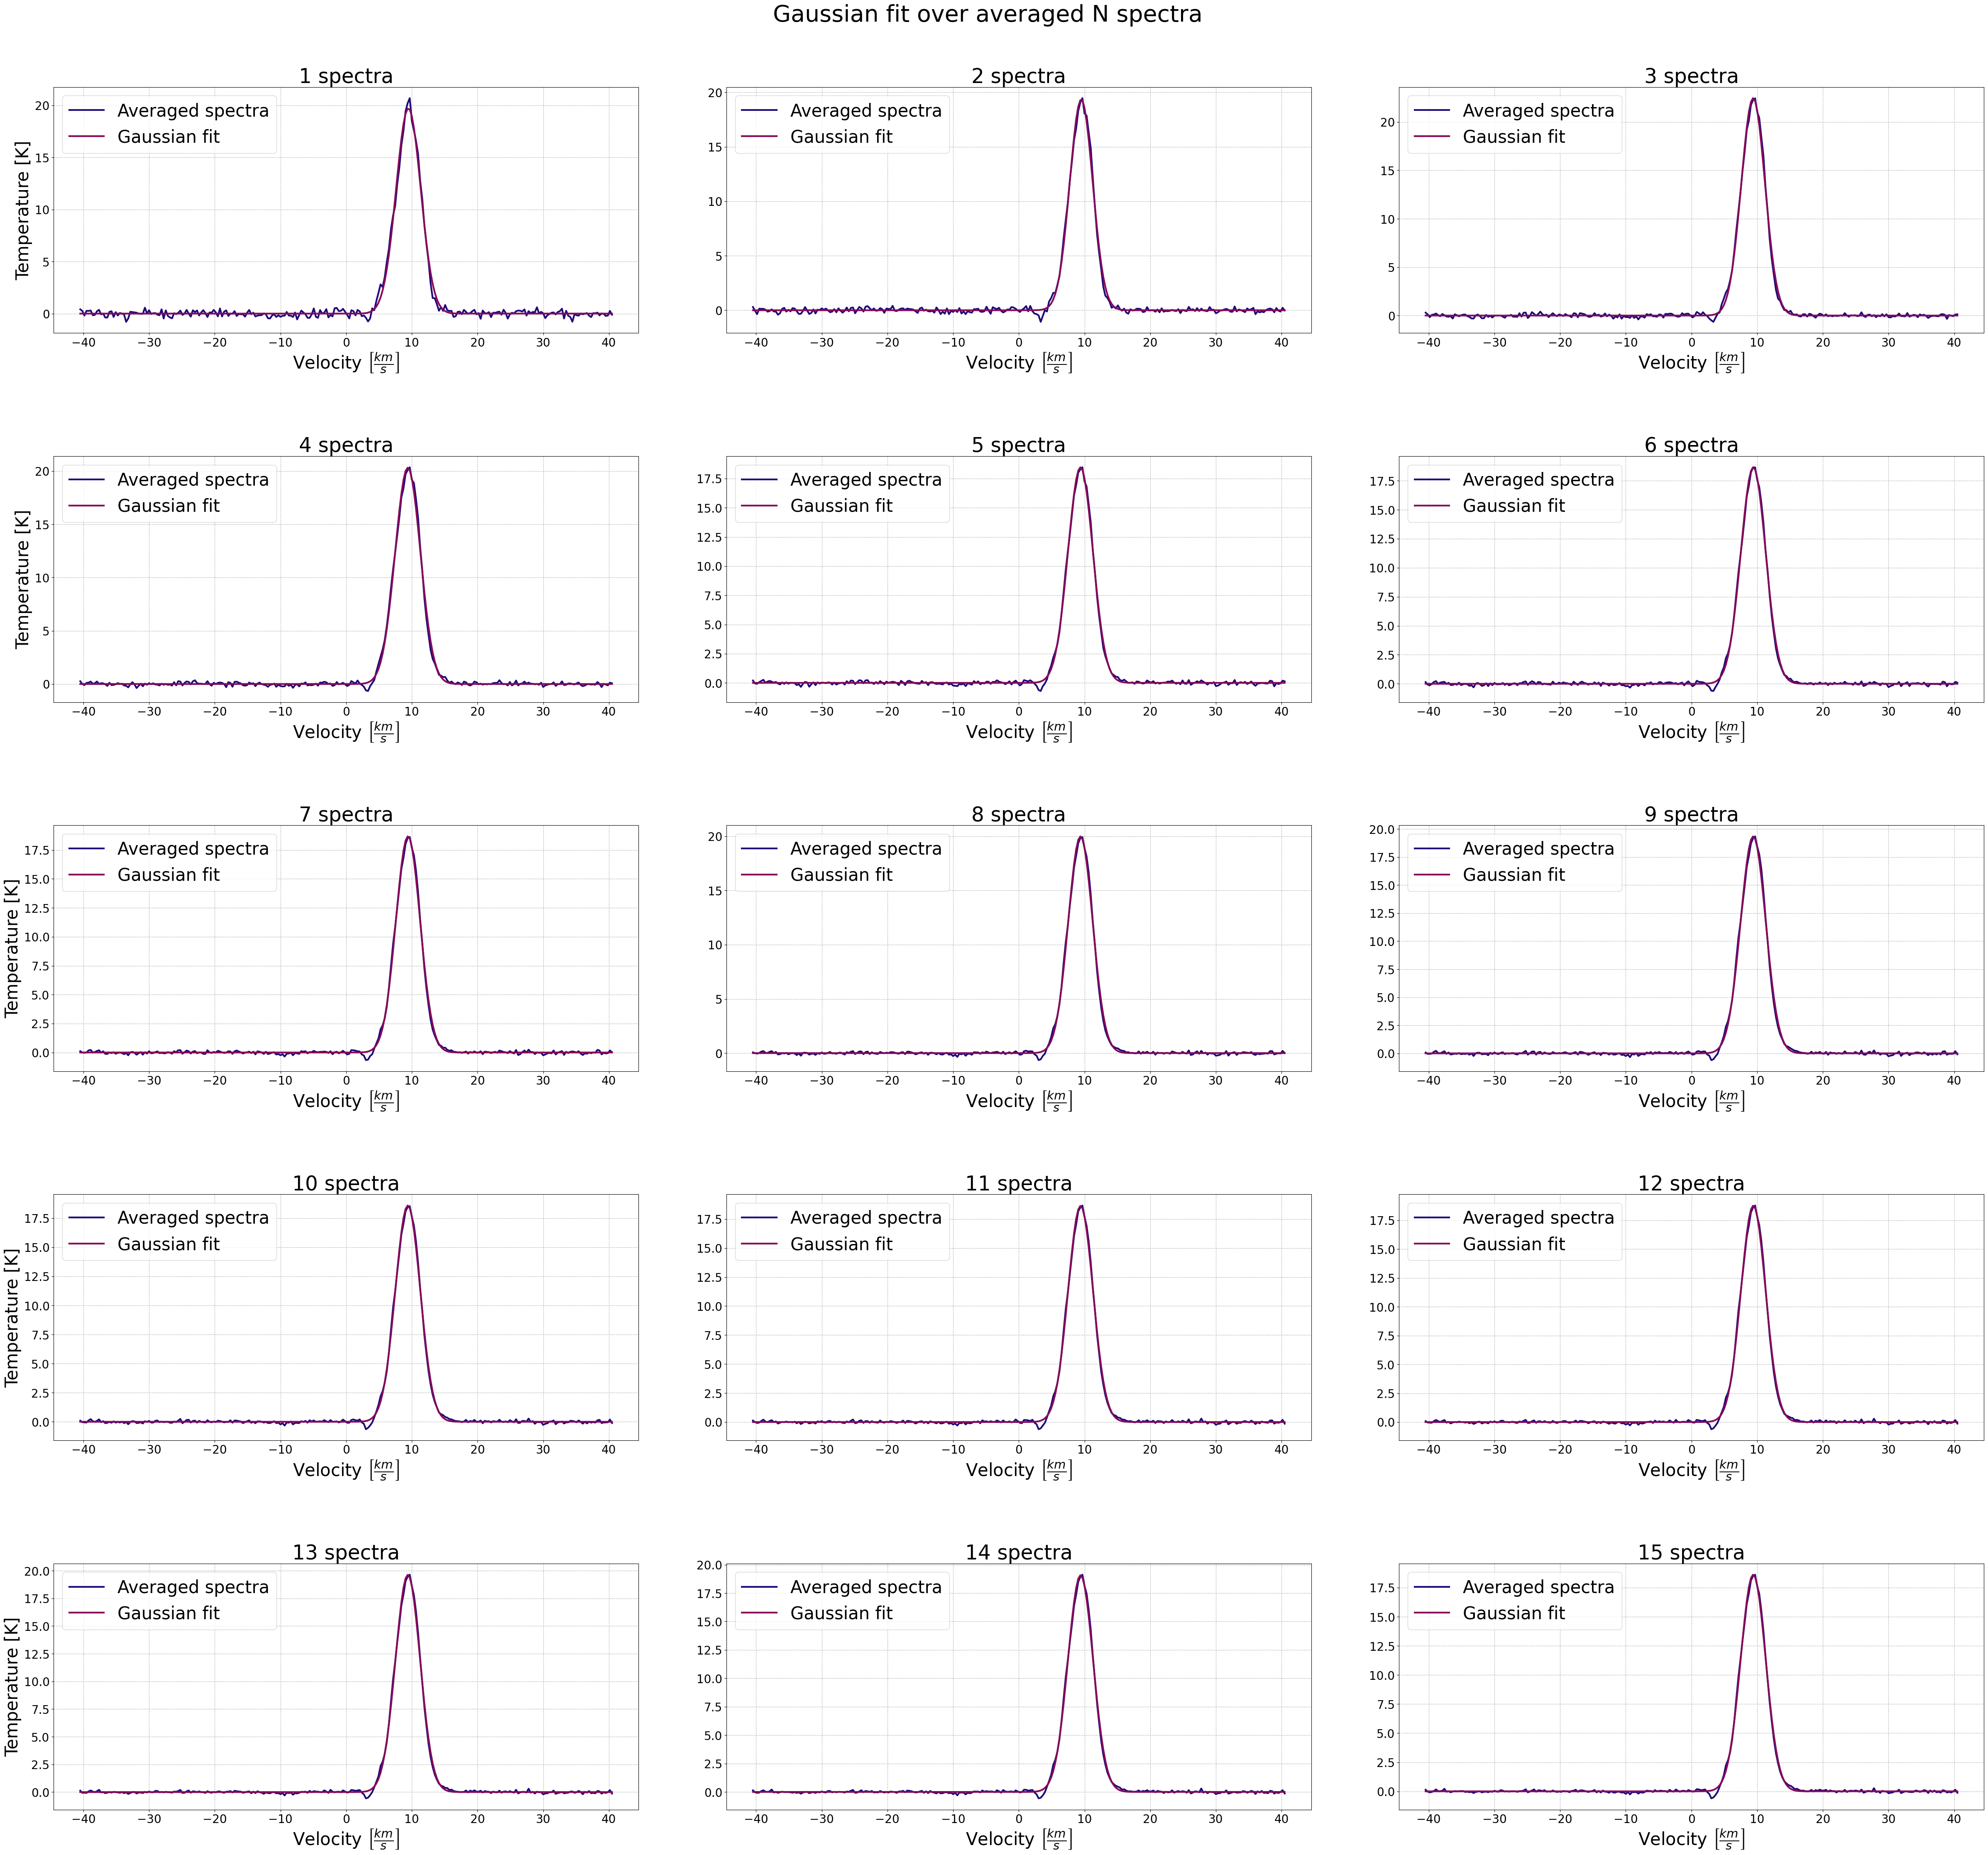

[0.34561934 0.25453143 0.2398201  0.23593678 0.17336186 0.16460438
 0.17378187 0.17848932 0.1816478  0.15353688 0.15262031 0.15402997
 0.15839386 0.16090212 0.14462833]


In [72]:
rms_i = []

fig, axes = plt.subplots(5, 3, figsize = (60, 50))

axes = axes.flatten()

for i in range(len(spec_T)):
    fg = [20, 10, 1] 

    coefs, cov = curve_fit(fn_gauss, v, means_T[i], p0=fg) 

    t0, M, S = coefs[0], coefs[1], coefs[2]

    gauss_fit = fn_gauss(v, t0, M, S)

    resta = means_T[i] - gauss_fit

    rms = np.std(resta)

    rms_i.append(rms)
    

    axes[i].plot(v, means_T[i], color = "#1f097a", linestyle = "-", linewidth = 3, label = 'Averaged spectra')
    axes[i].plot(v, gauss_fit, color = "#870959", linestyle = "-", linewidth = 3, label = 'Gaussian fit')
        
    axes[i].set_xlabel(r"Velocity $\left[ \frac{km}{s}\right]$", fontsize = 30)
    for j in [0, 3, 6, 9, 12]:
        axes[j].set_ylabel(r"Temperature [K]", fontsize = 30)

    axes[i].set_title(str(i + 1) + ' spectra', fontsize = 35)

    axes[i].grid(True, linestyle = "--", alpha = 0.9)
    axes[i].tick_params(labelsize = 20)
    axes[i].legend(fontsize = 30)
   
fig.suptitle('Gaussian fit over averaged N spectra', fontsize = 40)

fig.subplots_adjust(top = 0.94, hspace = 0.5, wspace = 0.15)
plt.show() 

rms_i = np.array(rms_i)

print(rms_i)

In [35]:
#count = 0
#for i in spectra_xy: 
    #count += 1
    # print(count - 1, i[0], i[1])

# Posiciones en spectra_FITS de las 3 pasadas sobre cada uno de los 5 puntos
posiciones = [[0, 5, 10], [1, 6, 11], [2, 7, 12], [3, 8, 13], [4, 9, 14]]
spec_T_pos = [[spec_T[i] for i in pos] for pos in posiciones]

means_T_pos = []
for i in spec_T_pos:
    stack_T = np.stack(i)
    avg_T = np.mean(stack_T, axis = 0)
    means_T_pos.append(avg_T)   

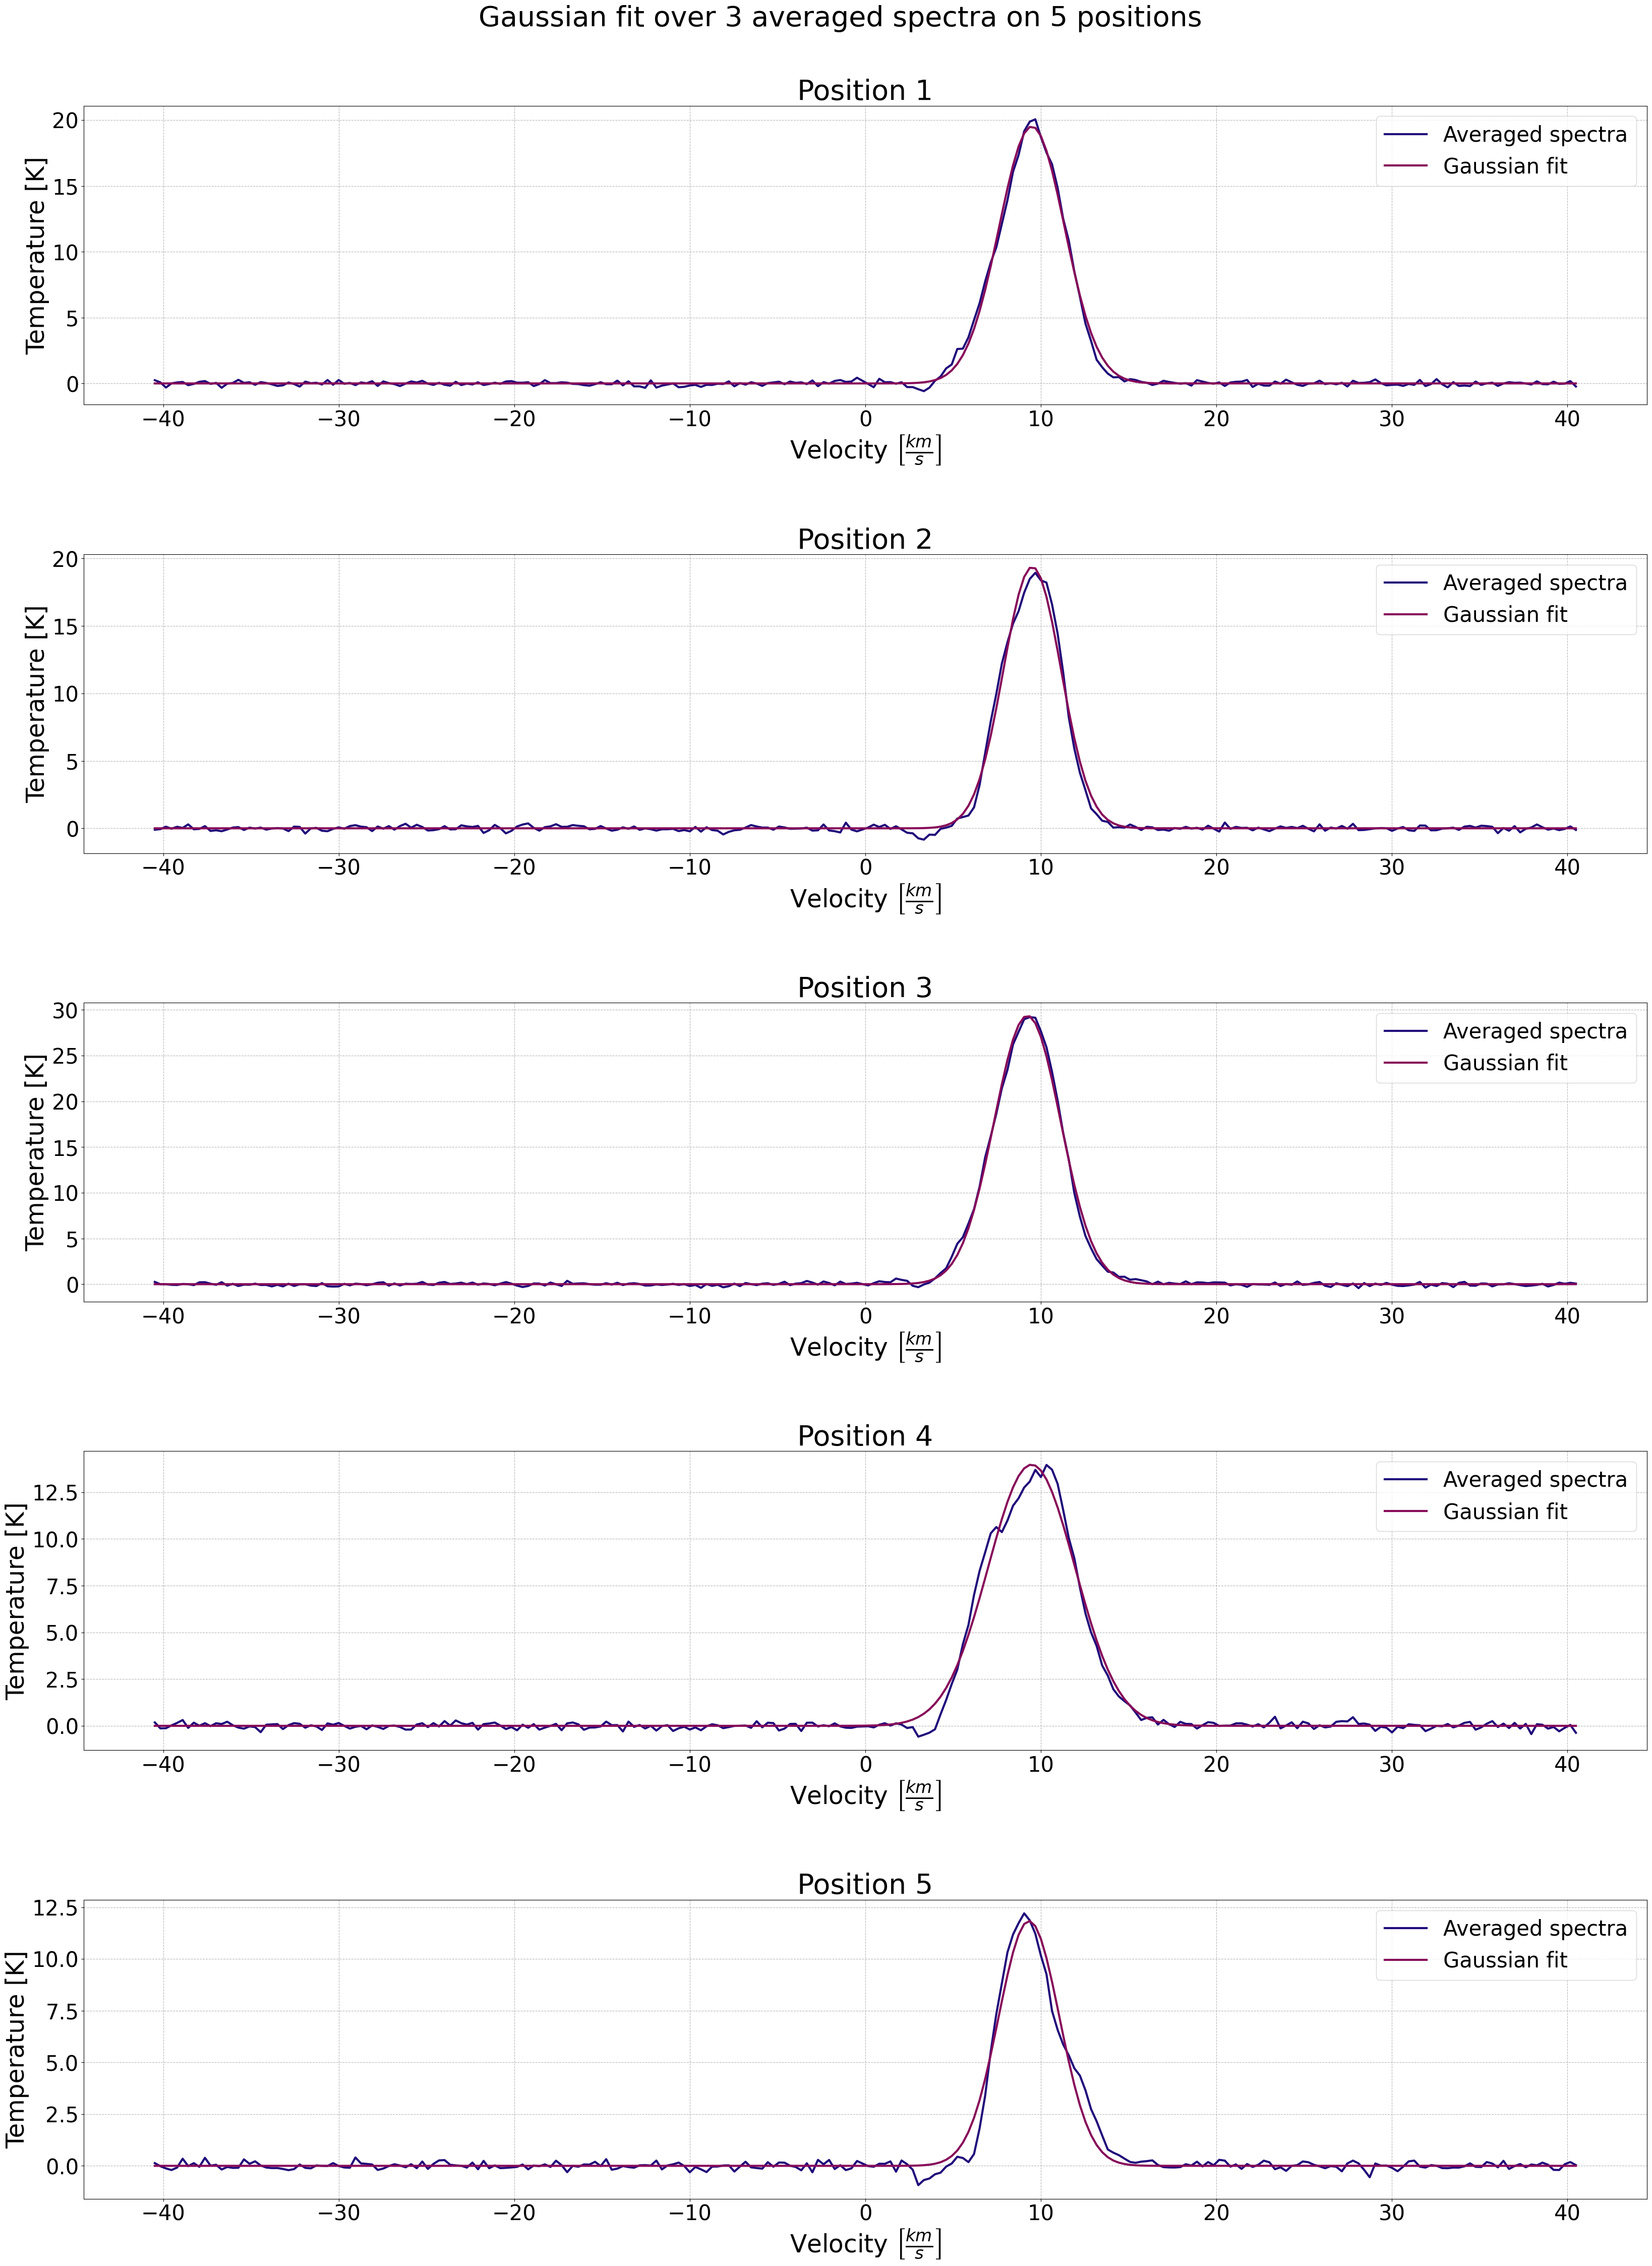

In [80]:
T_max = []

fig, axes = plt.subplots(5, 1, figsize = (40, 50))

axes = axes.flatten()

for i in range(len(means_T_pos)):
    fg = [20, 10, 1] 

    coefs, cov = curve_fit(fn_gauss, v, means_T_pos[i], p0=fg) 

    t0, M, S = coefs[0], coefs[1], coefs[2]

    T_max.append(t0)

    gauss_fit = fn_gauss(v, t0, M, S)

    axes[i].plot(v, means_T_pos[i], color = "#1f097a", linestyle = "-", linewidth = 3, label = 'Averaged spectra')
    axes[i].plot(v, gauss_fit, color = "#870959", linestyle = "-", linewidth = 3, label = 'Gaussian fit')
            
    axes[i].set_xlabel(r"Velocity $\left[ \frac{km}{s}\right]$", fontsize=35)
    axes[i].set_ylabel(r"Temperature [K]", fontsize=35)

    axes[i].set_title('Position ' + str(i + 1), fontsize = 40)

    axes[i].grid(True, linestyle = "--", alpha=0.9)
    axes[i].tick_params(labelsize = 30)
    axes[i].legend(fontsize = 30)
   
fig.suptitle('Gaussian fit over 3 averaged spectra on 5 positions', fontsize = 40)

fig.subplots_adjust(top = 0.94, hspace = 0.5)
plt.show() 

[(-19.260527, 208.996002), (-19.385527, 208.863495), (-19.385527, 208.996002), (-19.385527, 209.12851), (-19.510527, 208.996002)] [19.520433   19.38183522 29.359694   13.97525447 11.837612  ]


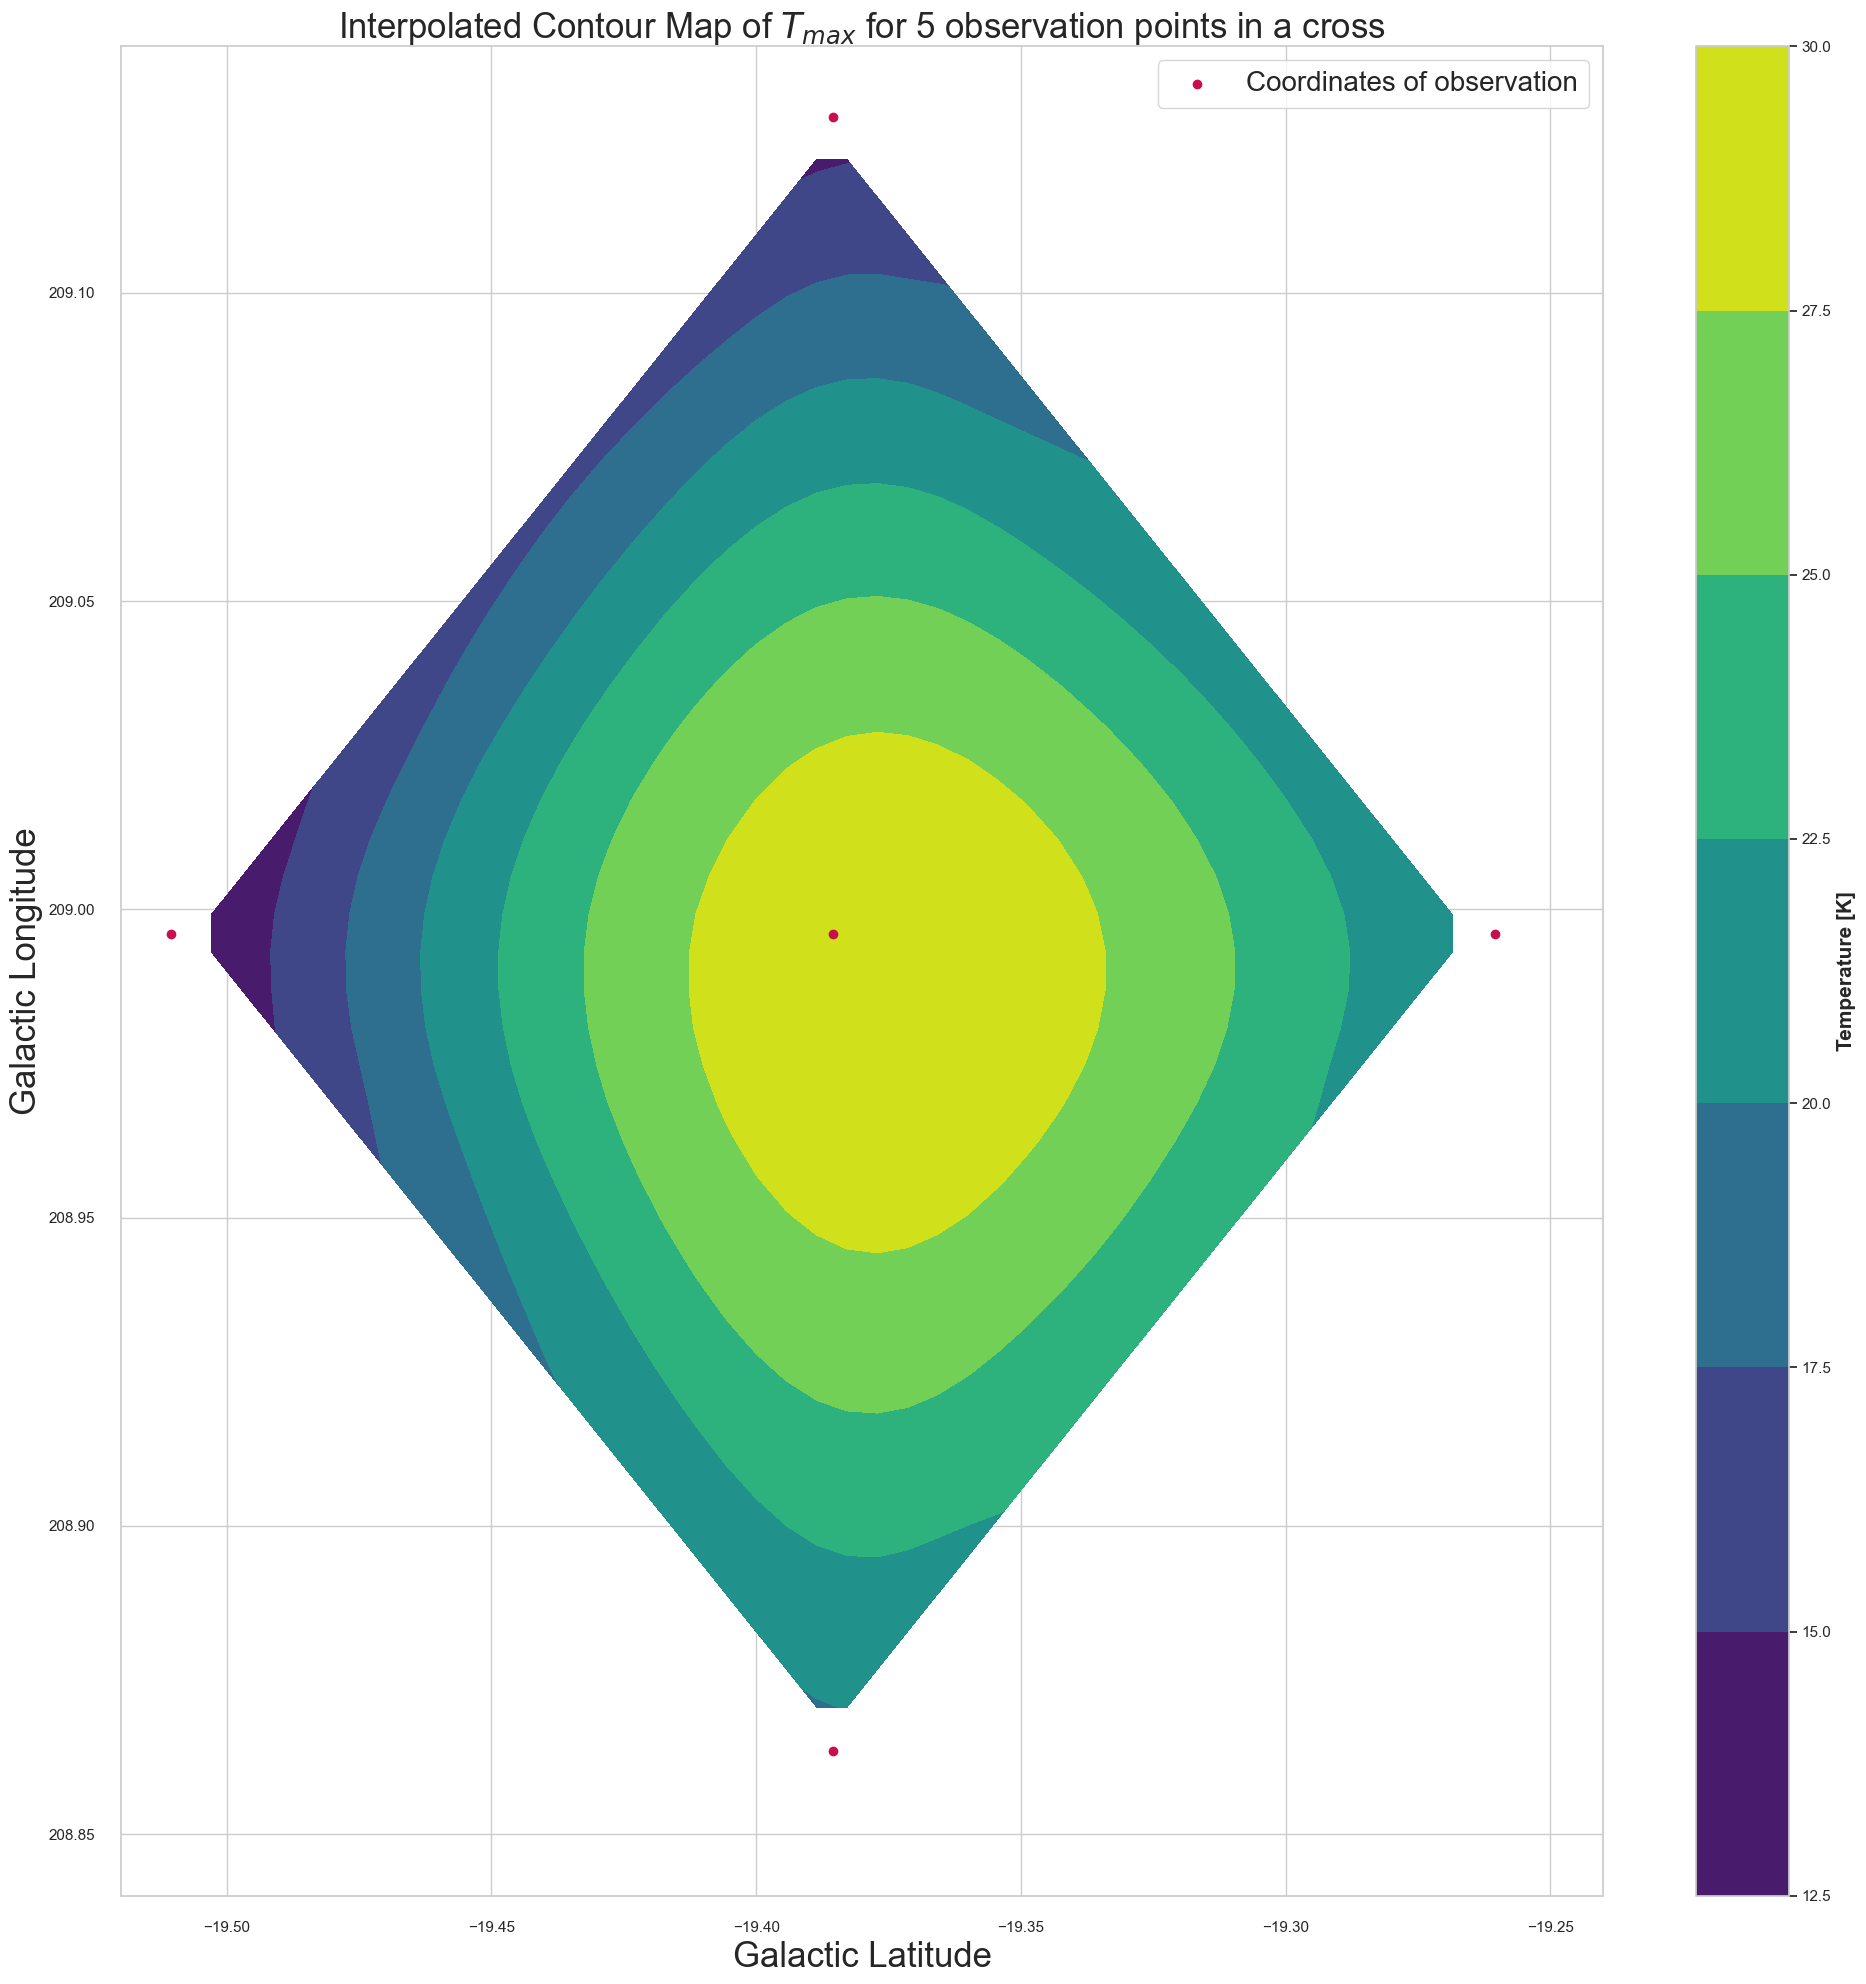

In [126]:
points = [(spectra_xy[i][0], spectra_xy[i][1]) for i in range(len(posiciones))]
print(points, 
      T_max)

points = np.array(points)

T_max = np.array(T_max)

gridx, gridy = np.mgrid[-19.52:-19.24:50j, 208.84:209.14:50j]

gridz = griddata(points, T_max, (gridx, gridy), method = 'cubic')

plt.figure(figsize = (20, 20), layout = 'tight')
plt.contourf(gridx, gridy, gridz, cmap = "viridis")
cb = plt.colorbar()
cb.set_label(label='Temperature [K]', weight='bold', size = 15)
plt.scatter(points[:, 0], points[:, 1], color = '#c90e50', label = 'Coordinates of observation', zorder = 5)
plt.title('Interpolated Contour Map of $T_{max}$ for 5 observation points in a cross', fontsize = 25)
plt.xlabel('Galactic Latitude', fontsize = 25)
plt.ylabel('Galactic Longitude', fontsize = 25)
plt.tick_params(size = 15)
plt.legend(fontsize = 20)
plt.show()
